# MC-3GS Training with NeRF Dataset Images

This notebook demonstrates training **Molecule-Constrained Gaussian Splatting**
using real multi-view images from a NeRF synthetic dataset.

## Overview
1. Load camera poses and images from `transforms_train.json`
2. Initialize a water molecule scene
3. Train the scene to match the target views
4. Visualize the optimization progress

**Note:** This demo uses water molecules to fit to lego images - obviously
this won't produce a perfect reconstruction! The goal is to demonstrate
the training pipeline with real image data from NeRF datasets.

**Computationally light setup:**
- Downscaled images (0.25x = 200x200)
- Only 8 training views (subset)
- 100 training iterations

In [ ]:
!wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/nerf_example_data.zip
!unzip nerf_example_data.zip

--2025-12-28 22:11:45--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/nerf_example_data.zip
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/nerf_example_data.zip [following]
--2025-12-28 22:11:45--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/nerf_example_data.zip
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 370385516 (353M) [application/zip]
Saving to: ‘nerf_example_data.zip.3’

nerf_example_data.z 100%[===================>] 353.23M   102MB/s    in 3.4s    

2025-12-28 22:11:49 (105 MB/s) - ‘nerf_example_data.zip.3’ saved [370385516/370385516]

Archive:  nerf_example_data.zip
caution: filename not matched:  -n


In [4]:
!pip install git+https://github.com/OliverVipond/mol-splat.git

  Cloning https://github.com/OliverVipond/mol-splat.git to /tmp/pip-req-build-x0kvka0n
  Running command git clone --filter=blob:none --quiet https://github.com/OliverVipond/mol-splat.git /tmp/pip-req-build-x0kvka0n
  Resolved https://github.com/OliverVipond/mol-splat.git to commit 2c1f948fdb5171dd122b39cbafe67eb859a4d084
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 1. Load NeRF Dataset

We load cameras and images from the `transforms_train.json` file.
This is the standard format used by NeRF synthetic datasets.

In [ ]:
# Path to the dataset
DATASET_PATH = Path("nerf_synthetic/lego")
TRANSFORMS_FILE = DATASET_PATH / "transforms_train.json"

# Load transforms
with open(TRANSFORMS_FILE) as f:
    transforms_data = json.load(f)

print(f"Loaded transforms from: {TRANSFORMS_FILE}")
print(f"  Camera angle X: {transforms_data['camera_angle_x']:.4f} rad")
print(f"  Number of frames: {len(transforms_data['frames'])}")

# Parameters
IMAGE_SCALE = 0.25  # Downscale for speed
NUM_TRAIN_VIEWS = 8  # Use subset of views
WHITE_BACKGROUND = True  # Blend alpha with white

# sRGB to linear RGB conversion (inverse gamma)
def srgb_to_linear(srgb):
    """Convert sRGB to linear RGB (undo gamma encoding).

    NeRF datasets are stored in sRGB color space, but our renderer
    operates in linear space. This conversion ensures colors match.
    """
    linear = np.where(
        srgb <= 0.04045,
        srgb / 12.92,
        ((srgb + 0.055) / 1.055) ** 2.4
    )
    return linear.astype(np.float32)

def linear_to_srgb(linear):
    """Convert linear RGB to sRGB for display.

    Apply gamma encoding so rendered images look correct on screen.
    """
    srgb = np.where(
        linear <= 0.0031308,
        12.92 * linear,
        1.055 * (linear ** (1.0 / 2.4)) - 0.055
    )
    return np.clip(srgb, 0, 1).astype(np.float32)

# Load a subset of cameras and images
def load_nerf_data(transforms_data, dataset_path, scale=0.25, num_views=8, device="cpu"):
    """Load cameras and images from NeRF transforms.json format."""
    cameras = []
    images = []

    angle_x = transforms_data["camera_angle_x"]
    frames = transforms_data["frames"][:num_views]

    for frame in frames:
        # Load image
        file_path = frame["file_path"]
        img_path = dataset_path / f"{file_path}.png"

        img = Image.open(img_path)
        orig_w, orig_h = img.size

        # Resize
        new_w = int(orig_w * scale)
        new_h = int(orig_h * scale)
        img = img.resize((new_w, new_h), Image.Resampling.LANCZOS)

        # Convert to numpy
        img_array = np.array(img, dtype=np.float32) / 255.0

        # Handle alpha channel (blend with white background)
        if img_array.shape[-1] == 4:
            rgb = img_array[..., :3]
            alpha = img_array[..., 3:4]
            img_array = rgb * alpha + (1 - alpha)  # White background

        # Convert from sRGB to linear RGB for training
        # NeRF images are stored in sRGB but our renderer operates in linear space
        img_array = srgb_to_linear(img_array)

        # To tensor [C, H, W]
        img_tensor = torch.from_numpy(img_array).permute(2, 0, 1).float().to(device)
        images.append(img_tensor)

        # Compute camera intrinsics
        focal = 0.5 * new_w / np.tan(0.5 * angle_x)
        K = torch.tensor(
            [[focal, 0, new_w / 2], [0, focal, new_h / 2], [0, 0, 1]],
            dtype=torch.float32,
            device=device,
        )

        # Camera extrinsics from transform matrix
        c2w = np.array(frame["transform_matrix"])

        # Convert camera-to-world to world-to-camera
        # NeRF uses OpenGL convention (camera looks down -Z, Y up)
        # Our renderer uses OpenCV convention (camera looks down +Z, Y down)
        # Apply coordinate flip: flip Y and Z axes
        flip_yz = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]], dtype=np.float32)

        R_w2c = c2w[:3, :3].T  # World to camera rotation
        t_w2c = -c2w[:3, :3].T @ c2w[:3, 3]  # World to camera translation

        # Apply OpenGL to OpenCV conversion
        R = torch.tensor(flip_yz @ R_w2c, dtype=torch.float32, device=device)
        t = torch.tensor(flip_yz @ t_w2c, dtype=torch.float32, device=device)
        center = torch.tensor(c2w[:3, 3], dtype=torch.float32, device=device)

        cameras.append({
            "K": K,
            "R": R,
            "t": t,
            "center": center,
            "width": new_w,
            "height": new_h,
        })

    return cameras, images

train_cameras, gt_images = load_nerf_data(
    transforms_data,
    DATASET_PATH,
    scale=IMAGE_SCALE,
    num_views=NUM_TRAIN_VIEWS,
    device=device,
)

print(f"\nLoaded {len(train_cameras)} training views")
print(f"  Image size: {gt_images[0].shape[1]}x{gt_images[0].shape[2]}")

Loaded transforms from: nerf_synthetic/lego/transforms_train.json
  Camera angle X: 0.6911 rad
  Number of frames: 100

Loaded 8 training views
  Image size: 200x200


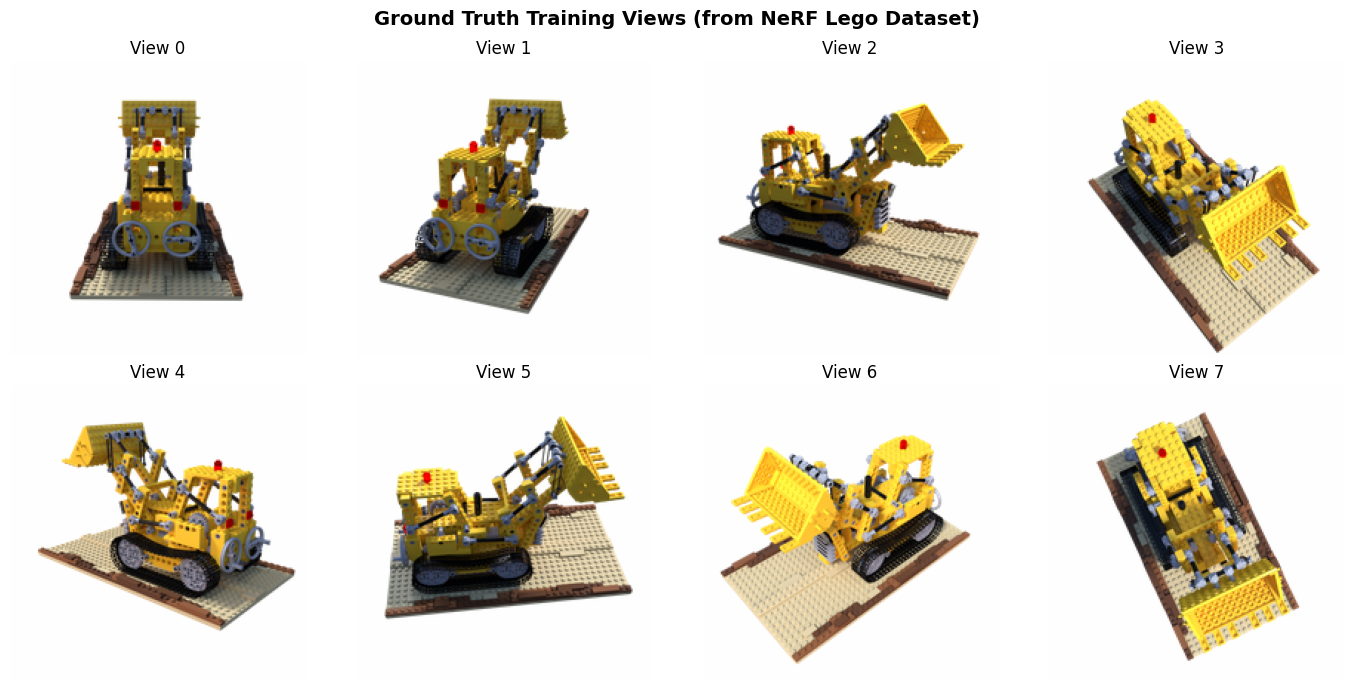

In [ ]:
# Visualize loaded ground truth images
# Note: GT images are now in linear space, convert to sRGB for display
fig, axes = plt.subplots(2, 4, figsize=(14, 7))

for idx, ax in enumerate(axes.flat):
    if idx < len(gt_images):
        img_np = gt_images[idx].permute(1, 2, 0).cpu().numpy()
        # Convert linear to sRGB for proper display
        img_np = linear_to_srgb(img_np)
        ax.imshow(img_np)
        ax.set_title(f"View {idx}")
    ax.axis("off")

plt.suptitle("Ground Truth Training Views (from NeRF Lego Dataset)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

## 2. Create Molecule Template

We create a water molecule template. Obviously water won't match
the lego bulldozer, but this demonstrates the pipeline!

For a real application, you would use a molecule that matches
your scene (e.g., if imaging actual molecules).

In [ ]:
from mc3gs.chemistry.rdkit_templates import create_template_from_smiles
from mc3gs.chemistry.typing import TypeVocabulary
from mc3gs.model import MoleculeInstance, MoleculeTemplate, Scene

# Create water molecule template
vocab = TypeVocabulary.default(include_bonds=True)

template_dict = create_template_from_smiles(
    "O",  # Water SMILES
    vocab=vocab,
    include_hydrogens=True,
    include_bonds=True,
)

template = MoleculeTemplate.from_chemistry_template(
    template_dict,
    vocab=vocab,
    name="Water",
)

print(f"Water molecule: {template.num_gaussians} Gaussians")
print(f"  - Atoms: {int((~template.is_bond_mask()).sum())}")
print(f"  - Bonds: {int(template.is_bond_mask().sum())}")

# Scale the template to be visible in the scene
# The lego scene is roughly centered at origin with radius ~4
# Use larger scale so molecules are more visible and colors can be learned effectively
template = template.centered().scale(0.5)

# Move template to GPU before creating instances
template = template.to(device)
print(f"Template moved to: {device}")

Water molecule: 5 Gaussians
  - Atoms: 3
  - Bonds: 2
Template moved to: cuda


## 3. Initialize Learnable Scene

We create a scene with water molecules positioned in the scene.
The optimization will adjust pose, scale, opacity, and colors
to best match the target images.

In [ ]:
# Create learnable scene with multiple water molecules
learn_scene = Scene()

N_WATER_MOLECULES = 200

# Add several water molecules at random positions
positions = [
    torch.tensor(
        np.random.uniform(-1.0, 1.0, size=(3,)), dtype=torch.float32
    )
    for _ in range(N_WATER_MOLECULES)
]

instances = []
for i, pos in enumerate(positions):
    instance = MoleculeInstance(
        template,
        sh_degree=0,
        init_position=pos,
        init_scale=0.2,  # Larger scale for more visible molecules
        init_opacity=0.99,  # Higher opacity
    )
    # Randomize initial colors to show that they can be learned
    with torch.no_grad():
        instance.atom_sh_bank.sh_coeffs.data += torch.randn_like(
            instance.atom_sh_bank.sh_coeffs
        ) * 0.3
        instance.bond_sh_bank.sh_coeffs.data += torch.randn_like(
            instance.bond_sh_bank.sh_coeffs
        ) * 0.2
    instances.append(instance)
    learn_scene.add_instance(instance)

learn_scene.to(device)

print(f"Created scene with {len(instances)} water molecules")
print(f"Total Gaussians: {learn_scene.total_gaussians}")

Created scene with 200 water molecules
Total Gaussians: 1000


In [ ]:
from mc3gs.render.splat_renderer import ReferenceSplatRenderer

# Initialize renderer
renderer = ReferenceSplatRenderer(device=device)

def render_scene(scene, camera, sh_degree=0, background_color=1.0):
    """Render a scene from a camera viewpoint."""
    data = scene.gather()

    result = renderer.render(
        positions=data["positions"],
        covariances=data["covariances"],
        opacities=data["opacities"],
        sh_coeffs=data["sh_coeffs"],
        K=camera["K"],
        R=camera["R"],
        t=camera["t"],
        camera_center=camera["center"],
        width=camera["width"],
        height=camera["height"],
        sh_degree=sh_degree,
        background=torch.ones(3, device=data["positions"].device) * background_color,
    )

    return result["image"]

print("Renderer initialized")

Renderer initialized


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 2.12 MiB is free. Process 19160 has 14.74 GiB memory in use. Of the allocated memory 14.06 GiB is allocated by PyTorch, and 567.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

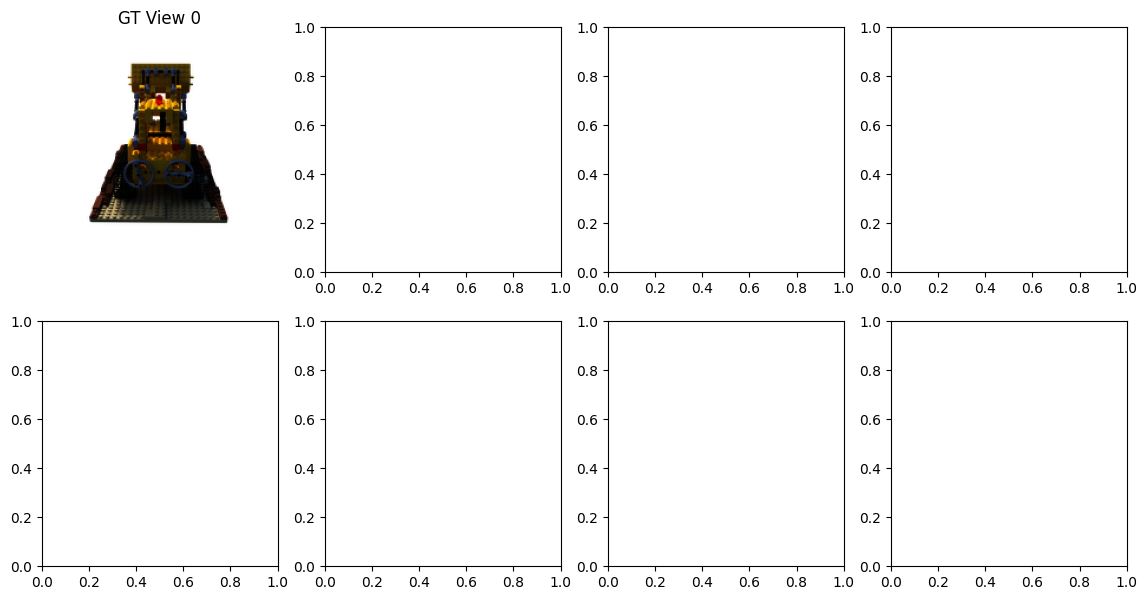

In [ ]:
# Compare initial state with ground truth
fig, axes = plt.subplots(2, 4, figsize=(14, 7))

with torch.no_grad():
    for i in range(4):
        # Ground truth
        gt_np = gt_images[i].permute(1, 2, 0).cpu().numpy()
        axes[0, i].imshow(np.clip(gt_np, 0, 1))
        axes[0, i].set_title(f"GT View {i}")
        axes[0, i].axis("off")

        # Initial prediction
        pred = render_scene(learn_scene, train_cameras[i], sh_degree=0, background_color=1.0)
        pred_np = pred.permute(1, 2, 0).cpu().numpy()
        axes[1, i].imshow(np.clip(pred_np, 0, 1))
        axes[1, i].set_title(f"Init View {i}")
        axes[1, i].axis("off")

plt.suptitle("Ground Truth (top) vs Initial Prediction (bottom)", fontsize=14)
plt.tight_layout()
plt.show()

## 4. Training Loop

Now we train the learnable scene to match the ground truth views
using photometric loss (L2 + SSIM).

**Note:** Since water molecules can't represent a lego bulldozer,
the optimization will just try to minimize the overall image error
by adjusting colors and positions. This demonstrates the pipeline
works with real images.

In [ ]:
from mc3gs.train.losses import ssim_loss

# Training configuration
n_iterations = 150
lr_pose = 0.1  # Learning rate for pose parameters
lr_color = 0.1 # Learning rate for color parameters

# Separate parameter groups with different learning rates
# This allows colors to learn faster while pose remains stable
pose_params = []
color_params = []
for inst in instances:
    pose_params.extend([inst.translation, inst.rotation, inst.log_scale, inst.logit_opacity])
    color_params.extend([inst.atom_sh_bank.sh_coeffs, inst.bond_sh_bank.sh_coeffs])

optimizer = torch.optim.Adam([
    {"params": pose_params, "lr": lr_pose},
    {"params": color_params, "lr": lr_color},
])

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=n_iterations, eta_min=lr_pose * 0.1
)

# Training history
history = {"loss": [], "psnr": [], "iteration": []}

print(f"Training for {n_iterations} iterations on {len(train_cameras)} views...")
print("(Note: Water molecules can't match lego, but this demonstrates the pipeline)\n")

for iteration in range(n_iterations):
    optimizer.zero_grad()

    total_loss = 0.0
    total_psnr = 0.0

    # Iterate over all views
    for cam_idx, camera in enumerate(train_cameras):
        # Render prediction (white background to match dataset)
        pred_img = render_scene(learn_scene, camera, sh_degree=0, background_color=1.0)

        # Get ground truth
        gt_img = gt_images[cam_idx]

        # L2 loss
        l2 = F.mse_loss(pred_img, gt_img)

        # SSIM loss (helps with structure)
        ssim = ssim_loss(pred_img.unsqueeze(0), gt_img.unsqueeze(0))

        # Combined loss
        loss = l2 + 0.2 * ssim
        total_loss += loss

        # PSNR for monitoring
        with torch.no_grad():
            mse = F.mse_loss(pred_img, gt_img)
            psnr = -10 * torch.log10(mse + 1e-8)
            total_psnr += psnr.item()

    # Average over views
    total_loss = total_loss / len(train_cameras)
    avg_psnr = total_psnr / len(train_cameras)

    # Backprop
    total_loss.backward()
    optimizer.step()
    scheduler.step()

    # Record history
    if iteration % 2 == 0 or iteration == n_iterations - 1:
        history["loss"].append(total_loss.item())
        history["psnr"].append(avg_psnr)
        history["iteration"].append(iteration)

        if iteration % 10 == 0:
            print(f"  Iter {iteration:3d}: Loss={total_loss.item():.4f}, PSNR={avg_psnr:.2f}dB")

print(f"\nTraining complete!")
print(f"  Final Loss: {history['loss'][-1]:.4f}")
print(f"  Final PSNR: {history['psnr'][-1]:.2f}dB")

Training for 150 iterations on 8 views...
(Note: Water molecules can't match lego, but this demonstrates the pipeline)



OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 2.12 MiB is free. Process 19160 has 14.74 GiB memory in use. Of the allocated memory 14.06 GiB is allocated by PyTorch, and 568.38 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history["iteration"], history["loss"], "b-", linewidth=2)
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.grid(True, alpha=0.3)

ax2.plot(history["iteration"], history["psnr"], "g-", linewidth=2)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("PSNR (dB)")
ax2.set_title("PSNR (higher is better)")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Results

Let's compare the final optimized renders with the ground truth.

In [ ]:
# Final comparison
fig, axes = plt.subplots(3, 4, figsize=(14, 10))

with torch.no_grad():
    for i in range(min(4, len(gt_images))):
        # Ground truth (convert linear to sRGB for display)
        gt_np = gt_images[i].permute(1, 2, 0).cpu().numpy()
        gt_srgb = linear_to_srgb(gt_np)
        axes[0, i].imshow(gt_srgb)
        axes[0, i].set_title(f"GT View {i}")
        axes[0, i].axis("off")

        # Optimized prediction (convert linear to sRGB for display)
        pred = render_scene(learn_scene, train_cameras[i], sh_degree=0, background_color=1.0)
        pred_np = pred.permute(1, 2, 0).cpu().numpy()
        pred_srgb = linear_to_srgb(pred_np)
        axes[1, i].imshow(pred_srgb)
        axes[1, i].set_title(f"Optimized View {i}")
        axes[1, i].axis("off")

        # Difference (computed in linear space, amplified for visibility)
        diff = np.abs(gt_np - pred_np) * 3
        axes[2, i].imshow(np.clip(diff, 0, 1))
        axes[2, i].set_title(f"Diff x3")
        axes[2, i].axis("off")

plt.suptitle("Ground Truth vs Optimized (with Difference)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [ ]:
# Show learned parameters (sample of first 10 instances)
with torch.no_grad():
    print("Learned Parameters (first 10 instances):")
    print("-" * 60)
    print(f"{'Instance':>8} | {'Position':^30} | {'Scale':>6} | {'Opacity':>7}")
    print("-" * 60)
    
    for idx, inst in enumerate(instances[:10]):
        pos = inst.translation.data
        scale = inst.scale.item()
        opacity = inst.opacity.mean().item()
        print(f"{idx:>8} | ({pos[0]:>7.2f}, {pos[1]:>7.2f}, {pos[2]:>7.2f}) | {scale:>6.3f} | {opacity:>7.3f}")
    
    if len(instances) > 10:
        print(f"... and {len(instances) - 10} more instances")

## Conclusion

This demo showed how to use MC-3GS with real images from NeRF datasets:

1. **Data Loading**: Load cameras and images from `transforms_train.json`
2. **Scene Setup**: Create molecule templates and initialize scene
3. **Training**: Optimize molecule parameters using photometric loss
4. **Evaluation**: Compare predictions with ground truth

### For Real Applications
- Use molecules that match your scene (e.g., actual molecular microscopy data)
- Increase training iterations and views
- Use higher SH degree for view-dependent effects
- Use CUDA backend for faster rendering at higher resolutions